In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score, mean_squared_error
from models.cluster.HierarchicalModel import HierarchicalModel
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = pd.read_csv('data/umist_cropped.csv')

In [3]:
X_train.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
1    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
2    234.0    234.0    234.0    234.0    234.0    234.0    234.0    233.0   
3    234.0    234.0    234.0    234.0    233.0    230.0    225.0    109.0   
4    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_8  pixel_9  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    234.0    233.0  ...        195.0        195.0        193.0        192.0   
1    234.0    234.0  ...        192.0        192.0        191.0        186.0   
2    225.0    186.0  ...        192.0        192.0        191.0        185.0   
3     85.0     84.0  ...        180.0        174.0        168.0        164.0   
4    234.0    234.0  ...        192.0        192.0        191.0        190.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        192.0        192.0        192.0        191.0        190.0   
1        183.0        179.0        174.0        169.0        165.0   
2        184.0        177.0        170.0        166.0        164.0   
3        157.0        152.0        151.0        148.0        145.0   
4        188.0        184.0        177.0        173.0        168.0   

   pixel_10303  
0        191.0  
1        164.0  
2        163.0  
3        145.0  
4        164.0  

[5 rows x 10304 columns]

In [4]:
X_train.shape

(600, 10304)

In [5]:
X_train = X_train.to_numpy()

In [6]:
# 1. Preprocess the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        8.79185122e-01, 8.73521205e-01, 8.78653648e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.68438150e-01, 7.47042410e-01, 7.42139003e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.53336290e-01, 7.41983259e-01, 7.37082905e-01],
       ...,
       [5.48521868e-05, 3.07863526e-04, 5.59110309e-04, ...,
        3.45586075e-01, 3.42310267e-01, 3.42707262e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.60485689e-01, 3.47369419e-01, 3.47763360e-01],
       [2.12060911e-02, 2.42945046e-02, 2.70870474e-02, ...,
        3.13761583e-01, 3.09032464e-01, 3.04843503e-01]])

In [7]:
# 2. Apply PCA to Retain 99.5% Variance
pca = PCA(n_components=0.995)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components chosen by PCA: {X_pca.shape[1]}")

Number of components chosen by PCA: 422


Neighborhood Preservation Metric - to check UMAP component

In [8]:
from sklearn.metrics import pairwise_distances
import numpy as np
import umap

neighborhood_preservation = []
for n in range(2, 21):  # Test components from 2 to 20
    # Reduce data
    reducer = umap.UMAP(n_components=n, random_state=123)
    reduced_data = reducer.fit_transform(X_pca)
    
    # Compute pairwise distances
    original_distances = pairwise_distances(X_pca)
    reduced_distances = pairwise_distances(reduced_data)
    
    # Compare nearest neighbors
    top_k = 10  # Number of neighbors to consider
    original_neighbors = np.argsort(original_distances, axis=1)[:, :top_k]
    reduced_neighbors = np.argsort(reduced_distances, axis=1)[:, :top_k]
    preservation = np.mean([
        len(set(original_neighbors[i]) & set(reduced_neighbors[i])) / top_k
        for i in range(len(X_pca))
    ])
    neighborhood_preservation.append((n, preservation))

In [9]:
sorted_results = sorted(neighborhood_preservation, key=lambda x: x[1], reverse=True)
for n, preservation  in sorted_results:
    print(f"Components: {n}, Neighborhood Preservation: {preservation}")

Components: 7, Neighborhood Preservation: 0.7026666666666667
Components: 19, Neighborhood Preservation: 0.7023333333333333
Components: 10, Neighborhood Preservation: 0.7011666666666666
Components: 15, Neighborhood Preservation: 0.7010000000000001
Components: 20, Neighborhood Preservation: 0.7008333333333333
Components: 17, Neighborhood Preservation: 0.7005
Components: 12, Neighborhood Preservation: 0.6993333333333334
Components: 4, Neighborhood Preservation: 0.6988333333333333
Components: 6, Neighborhood Preservation: 0.6981666666666666
Components: 11, Neighborhood Preservation: 0.6976666666666667
Components: 18, Neighborhood Preservation: 0.6976666666666667
Components: 16, Neighborhood Preservation: 0.6975
Components: 8, Neighborhood Preservation: 0.697
Components: 14, Neighborhood Preservation: 0.6966666666666667
Components: 13, Neighborhood Preservation: 0.6965
Components: 9, Neighborhood Preservation: 0.6960000000000001
Components: 5, Neighborhood Preservation: 0.6906666666666667
C

In [10]:
least_error_component = sorted_results[0][0]
print(f"The highest Neighborhood Preservation: {least_error_component}")

The highest Neighborhood Preservation: 7


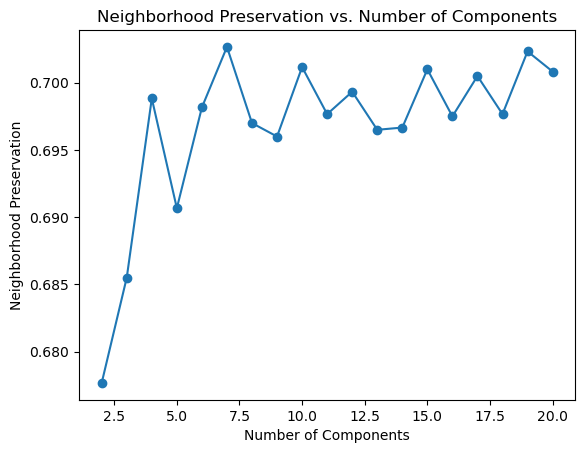

In [11]:
# Extract values for plotting
components = [n for n, _ in neighborhood_preservation]
preservation = [preservation for _, preservation in neighborhood_preservation]

# Plot the reconstruction error
plt.plot(components, preservation, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Neighborhood Preservation')
plt.title('Neighborhood Preservation vs. Number of Components')
plt.show()

In [12]:
# Apply final the best number of component for UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=least_error_component, random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[1.5857029, 4.2022576, 8.334184 , ..., 3.35107  , 5.515199 ,
        6.3131266],
       [1.6797055, 4.1183715, 8.420249 , ..., 3.3914518, 5.644021 ,
        6.2884197],
       [1.6493722, 4.0730634, 8.457553 , ..., 3.3712704, 5.634795 ,
        6.2606373],
       ...,
       [8.628194 , 9.595672 , 4.8236423, ..., 4.0012445, 2.9891486,
        6.1237717],
       [8.665291 , 9.482118 , 4.8439975, ..., 4.01278  , 3.0496004,
        6.1042633],
       [8.682006 , 9.5502615, 4.82096  , ..., 4.0167007, 3.003234 ,
        6.098212 ]], dtype=float32)

In [13]:
# Initialize Agglomerative Clustering
expected_cluster = 20
agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric='euclidean', linkage='ward')
# Fit the model and predict cluster labels
cluster_labels = agg_cluster.fit_predict(X_umap)
agg_cluster_labels = cluster_labels

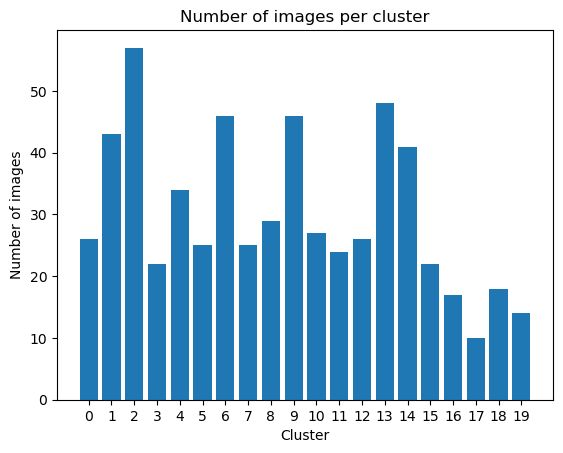

In [14]:
plt.bar(range(expected_cluster), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(expected_cluster))
plt.show()

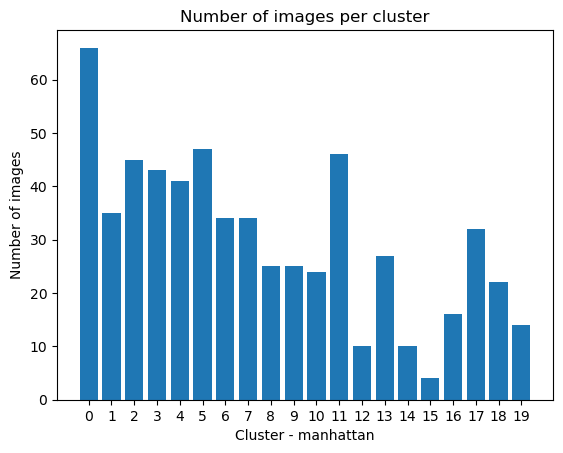

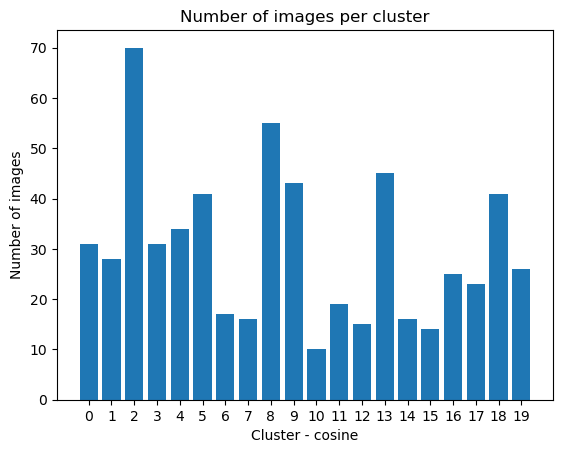

In [15]:
metrics = ['manhattan', 'cosine']
expected_cluster = 20

for met in metrics:
    agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric=met, linkage='average')
    
    # Fit the model and predict cluster labels
    cluster_labels = agg_cluster.fit_predict(X_umap)

    plt.bar(range(expected_cluster), np.bincount(cluster_labels))
    plt.xlabel(f'Cluster - {met}')
    plt.ylabel('Number of images')
    plt.title('Number of images per cluster')
    plt.xticks(range(expected_cluster))
    plt.show() 

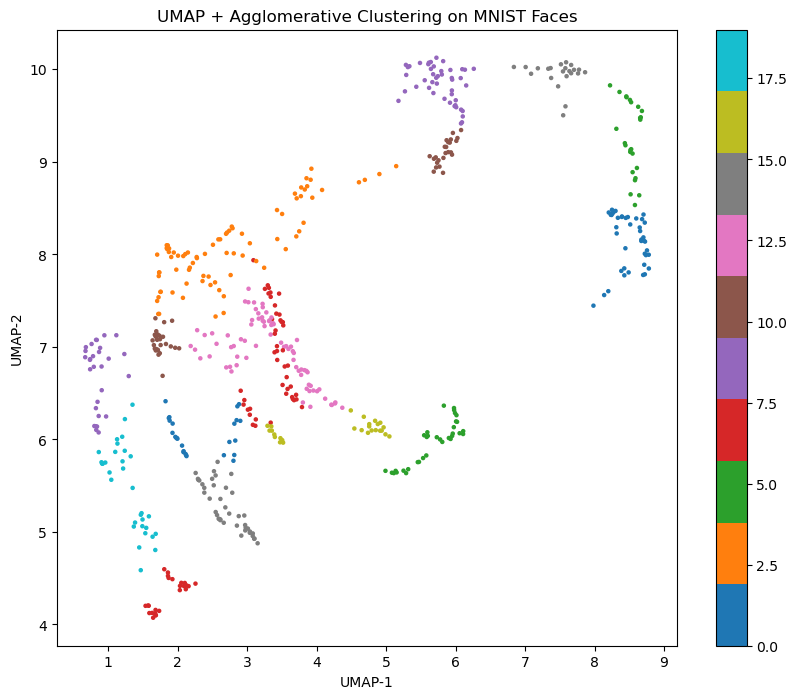

In [16]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=agg_cluster_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("UMAP + Agglomerative Clustering on MNIST Faces")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [17]:
# Measure the quality of clustering (higher is better for silhouette score)
silhouette = silhouette_score(X_umap, agg_cluster_labels)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.47


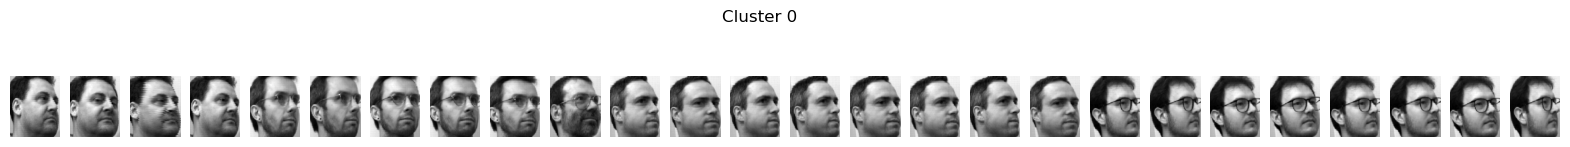

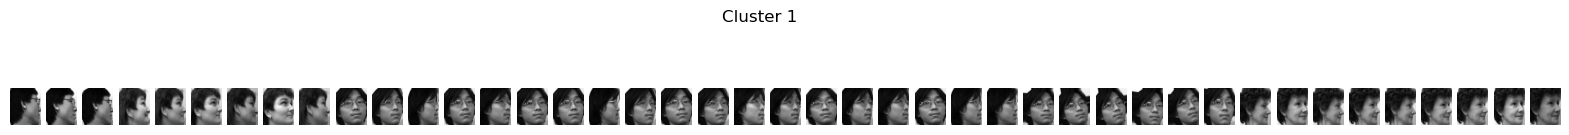

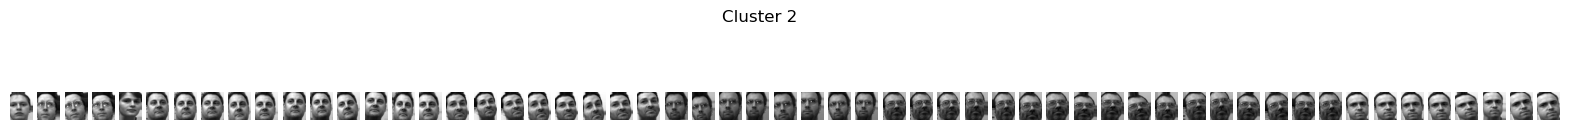

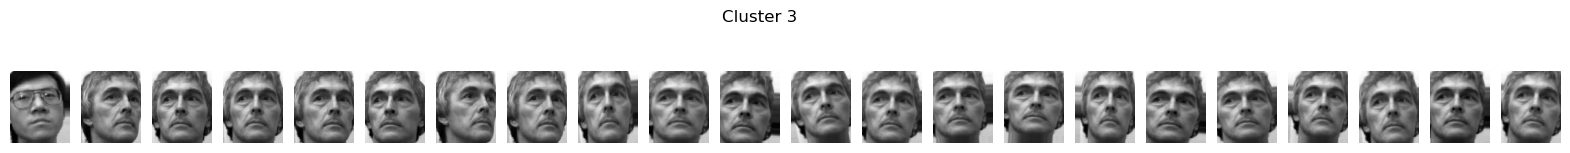

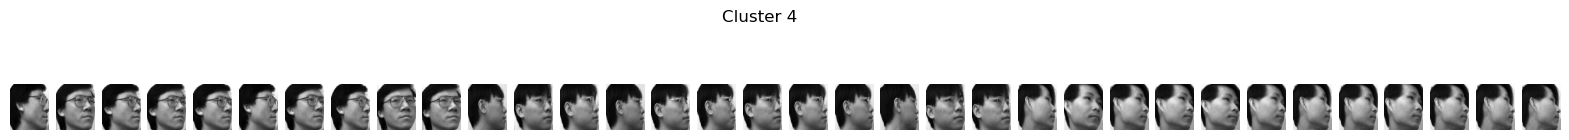

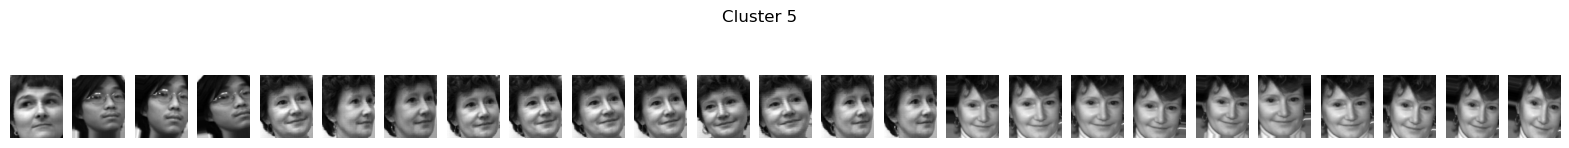

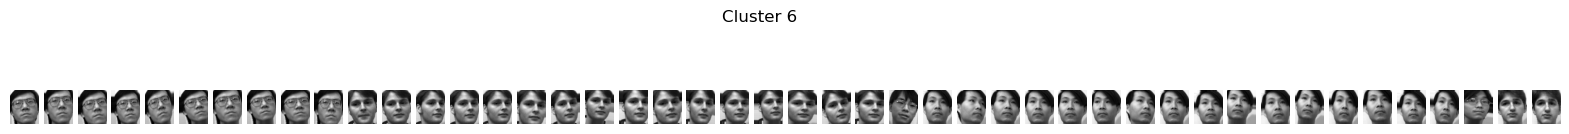

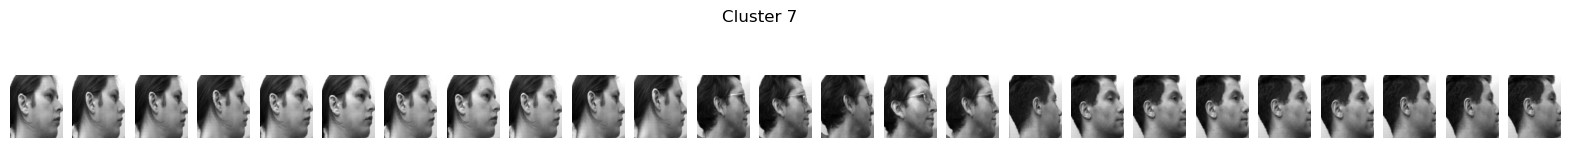

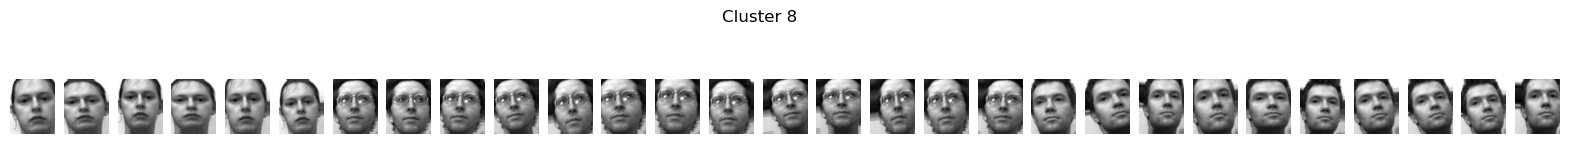

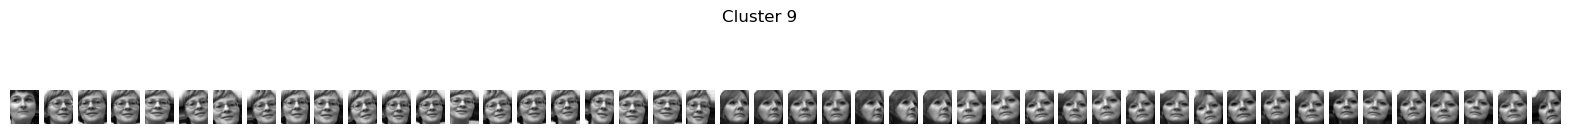

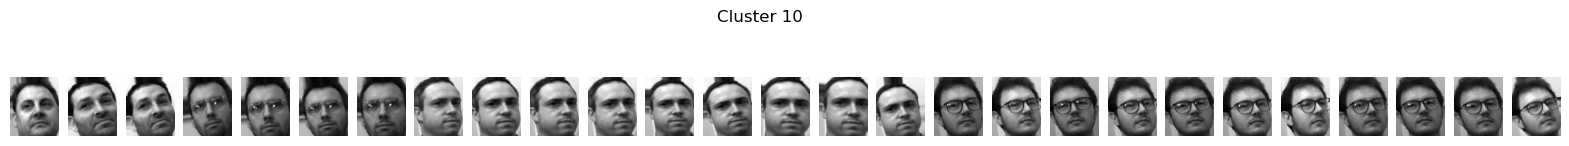

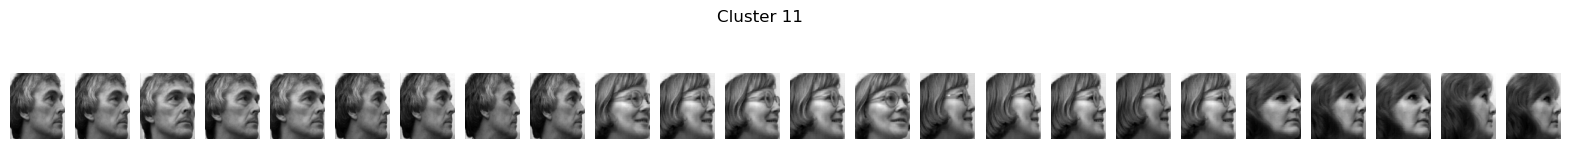

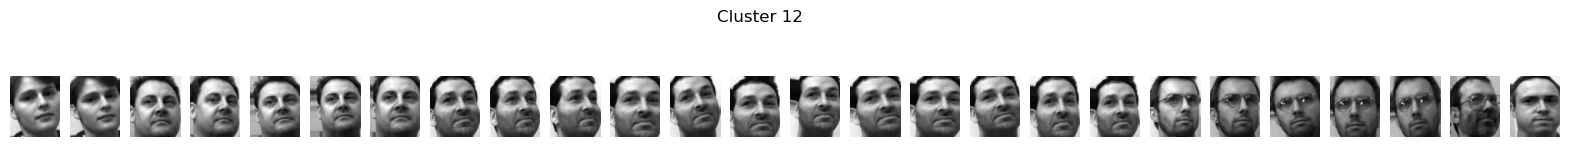

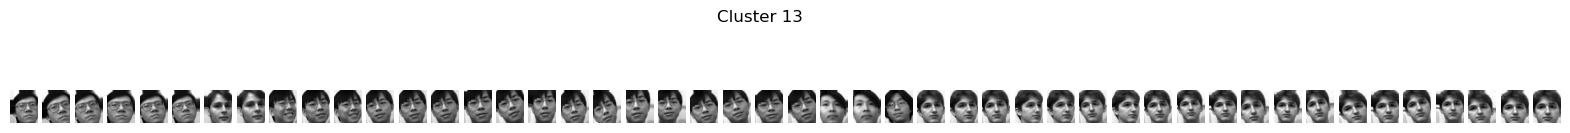

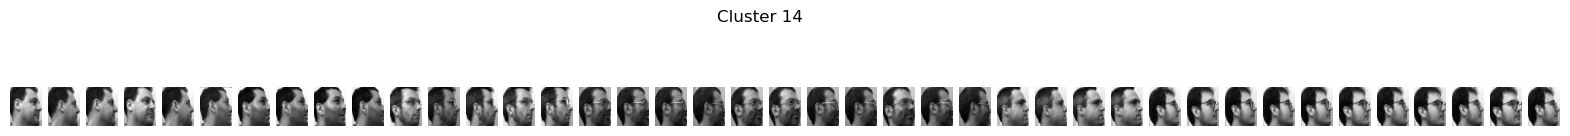

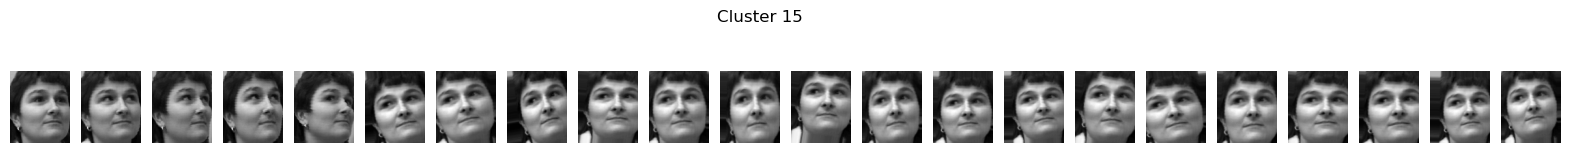

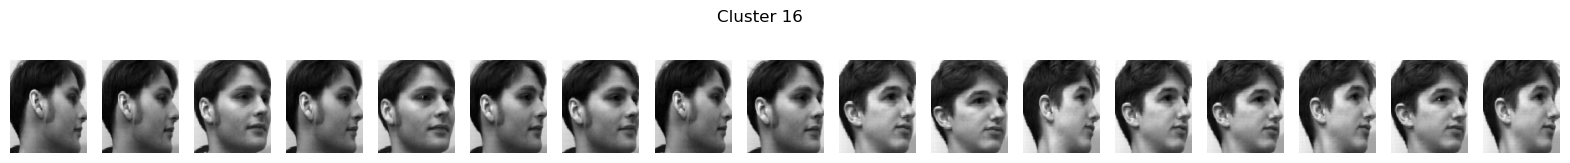

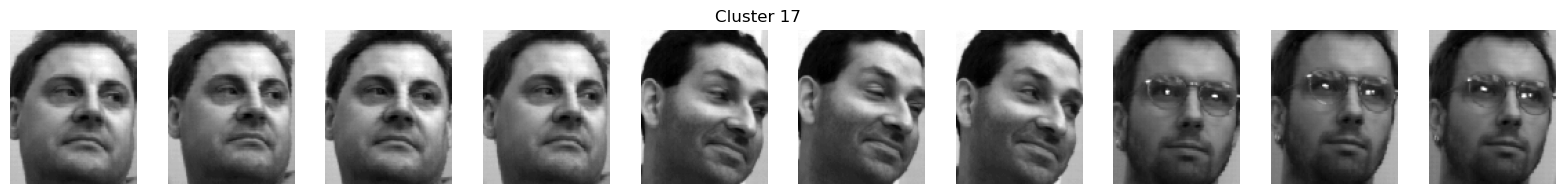

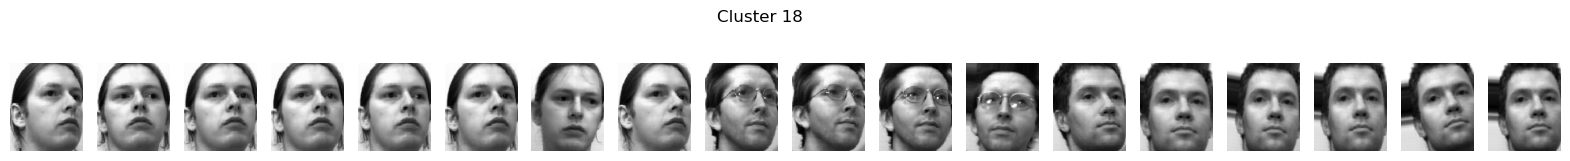

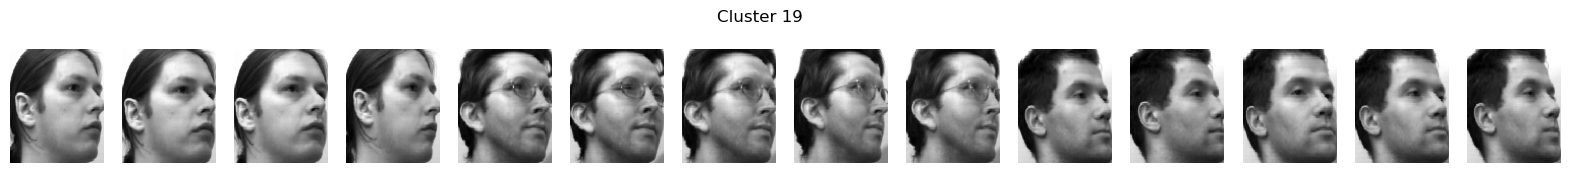

In [18]:
def plot_result(cluster_labels, cluster_num):
    for cluster_id in range(cluster_num+1):
        # Get the indices of images in the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Determine the number of images to plot
        num_images = len(cluster_indices)
        
        if num_images > 0:
            fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
            
            # Handle the case where there is only one image
            if num_images == 1:
                axes = [axes]  # Convert single axis to a list for consistency
            
            for i in range(num_images):
                # Get the image index
                image_index = cluster_indices[i]
                
                # Get the image data
                image_data = X_train[image_index]
                
                # Reshape the image data
                image_data = image_data.reshape(112, 92)
                
                # Plot the image
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
            plt.suptitle(f"Cluster {cluster_id}")
            plt.show()
plot_result(agg_cluster_labels, expected_cluster)

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.4772084653377533


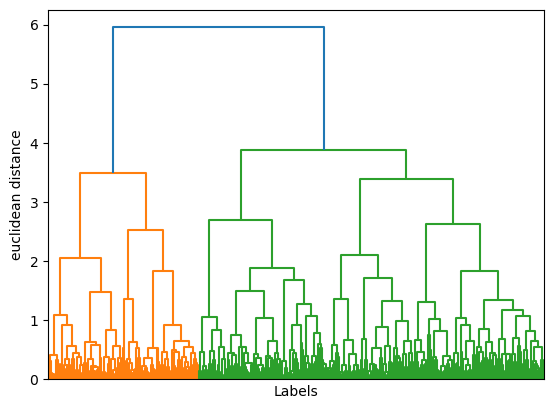

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.48726061180373376


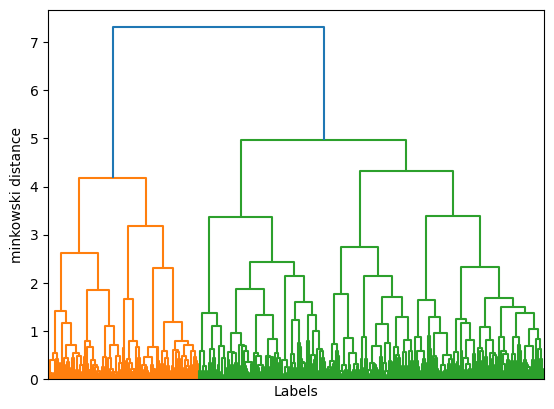

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.602756679058075


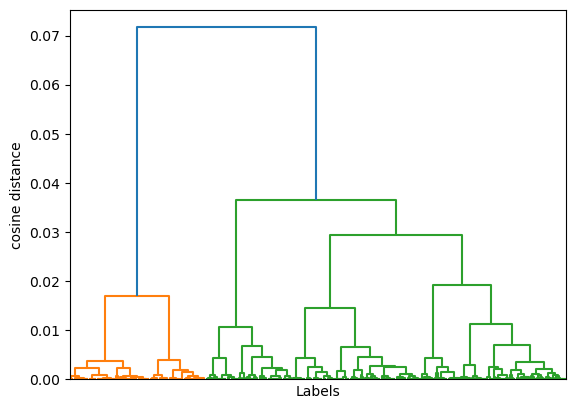

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.4628645380328936


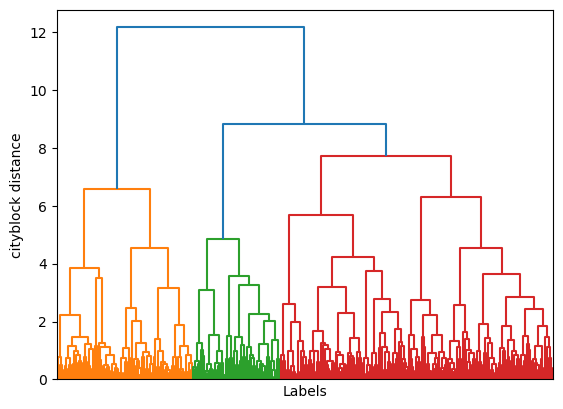

In [19]:
metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']       
                
results = {}
square_distances_matrix = []
clusters_res = []

for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    
    if m == 'minkowski':
        Y = pdist(X_umap, metric=m, p=1.5)
    else:
        Y = pdist(X_umap, metric=m)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = silhouette_score(X_umap, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

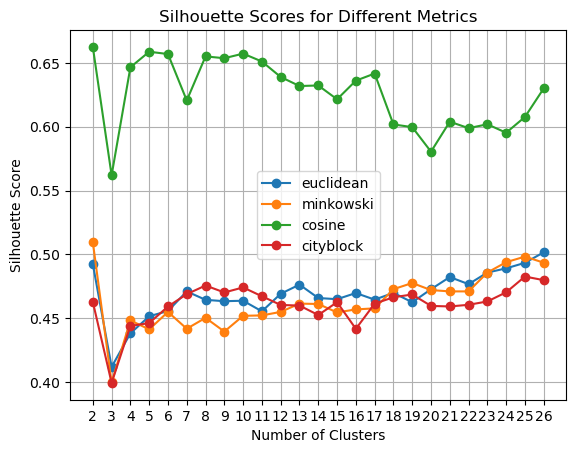

In [20]:
max_clusters = 26  # Maximum number of clusters to test
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_umap, metric=metric, p=1.5)
        else:
            Y = pdist(X_umap, metric=metric)
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='centroid')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = silhouette_score(X_umap, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

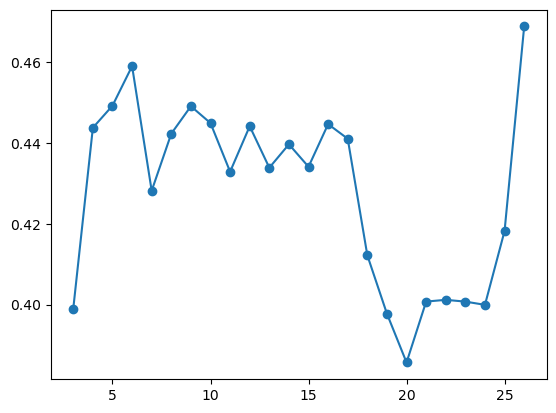

In [21]:
silhouette_scores = []
best_cluster_num = 1
best_score = 0

for n_clusters in range(3, max_clusters + 1):  # Start from 2 clusters
    Y = pdist(X_umap, metric='cosine')
    Z = linkage(Y, method='centroid')
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    num_clusters_formed = len(set(clusters))
    if num_clusters_formed > 1:
        silhouette = silhouette_score(X_umap, clusters, metric=metric)
        silhouette_scores.append(silhouette)
        if silhouette > best_score:
            best_score = silhouette
            best_cluster_num = num_clusters_formed
    else:
        silhouette_scores.append(-1)  # Append a negative score or None if not valid
# Plotting
plt.plot(range(3, max_clusters + 1), silhouette_scores, marker='o', label=metric)
plt.show()

In [22]:
print(f'The best cluster number: {best_cluster_num} with score {best_score}')

The best cluster number: 26 with score 0.46886284110431403


In [23]:
original_data = pd.read_csv("data/umist_with_original_face_id.csv")

In [24]:
original_labels = original_data['label']
original_labels = original_labels.to_numpy()

Result for metric = Cosine and linkage = Centroid

Cluster labels for each image: Counter({4: 47, 6: 45, 18: 43, 11: 41, 24: 37, 20: 31, 14: 26, 22: 26, 8: 25, 12: 23, 1: 23, 5: 23, 2: 22, 17: 20, 15: 19, 26: 19, 21: 18, 16: 17, 19: 16, 25: 15, 10: 15, 7: 14, 23: 13, 9: 10, 13: 8, 3: 4})


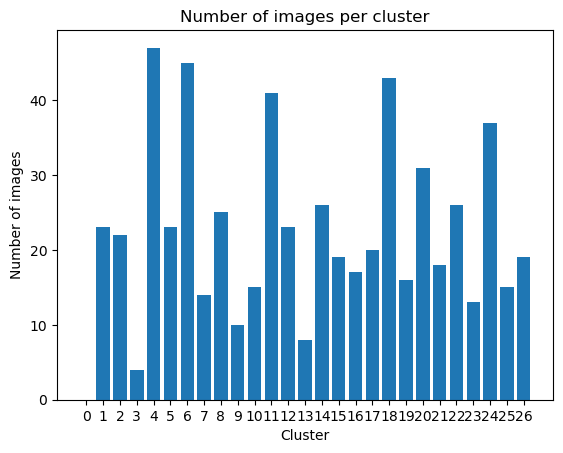

In [25]:
model = HierarchicalModel(best_cluster_num, 'centroid', 'cosine')
cosine_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(cosine_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(cosine_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 2: Majority label 6 with 22 images (100.0%)
Cluster 3: Majority label 4 with 4 images (100.0%)
Cluster 4: Majority label 8 with 25 images (53.2%)
Cluster 5: Majority label 19 with 20 images (87.0%)
Cluster 6: Majority label 11 with 26 images (57.8%)
Cluster 10: Majority label 17 with 8 images (53.3%)
Cluster 13: Majority label 3 with 8 images (100.0%)
Cluster 16: Majority label 10 with 14 images (82.4%)
Cluster 17: Majority label 5 with 15 images (75.0%)
Cluster 21: Majority label 4 with 17 images (94.4%)
Cluster 25: Majority label 17 with 15 images (100.0%)
Cluster 26: Majority label 18 with 12 images (63.2%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 8: Majority label 0 with 11 images (44.0%)
Cluster 19: Majority label 0 with 8 images (50.0%)
Cluster 7: Majority label 1 with 5 images (35.7%)
Cluster 20: Majority label 1 with 14 images (45.2%)
Cluster 15: Majority label 3 with 9 ima

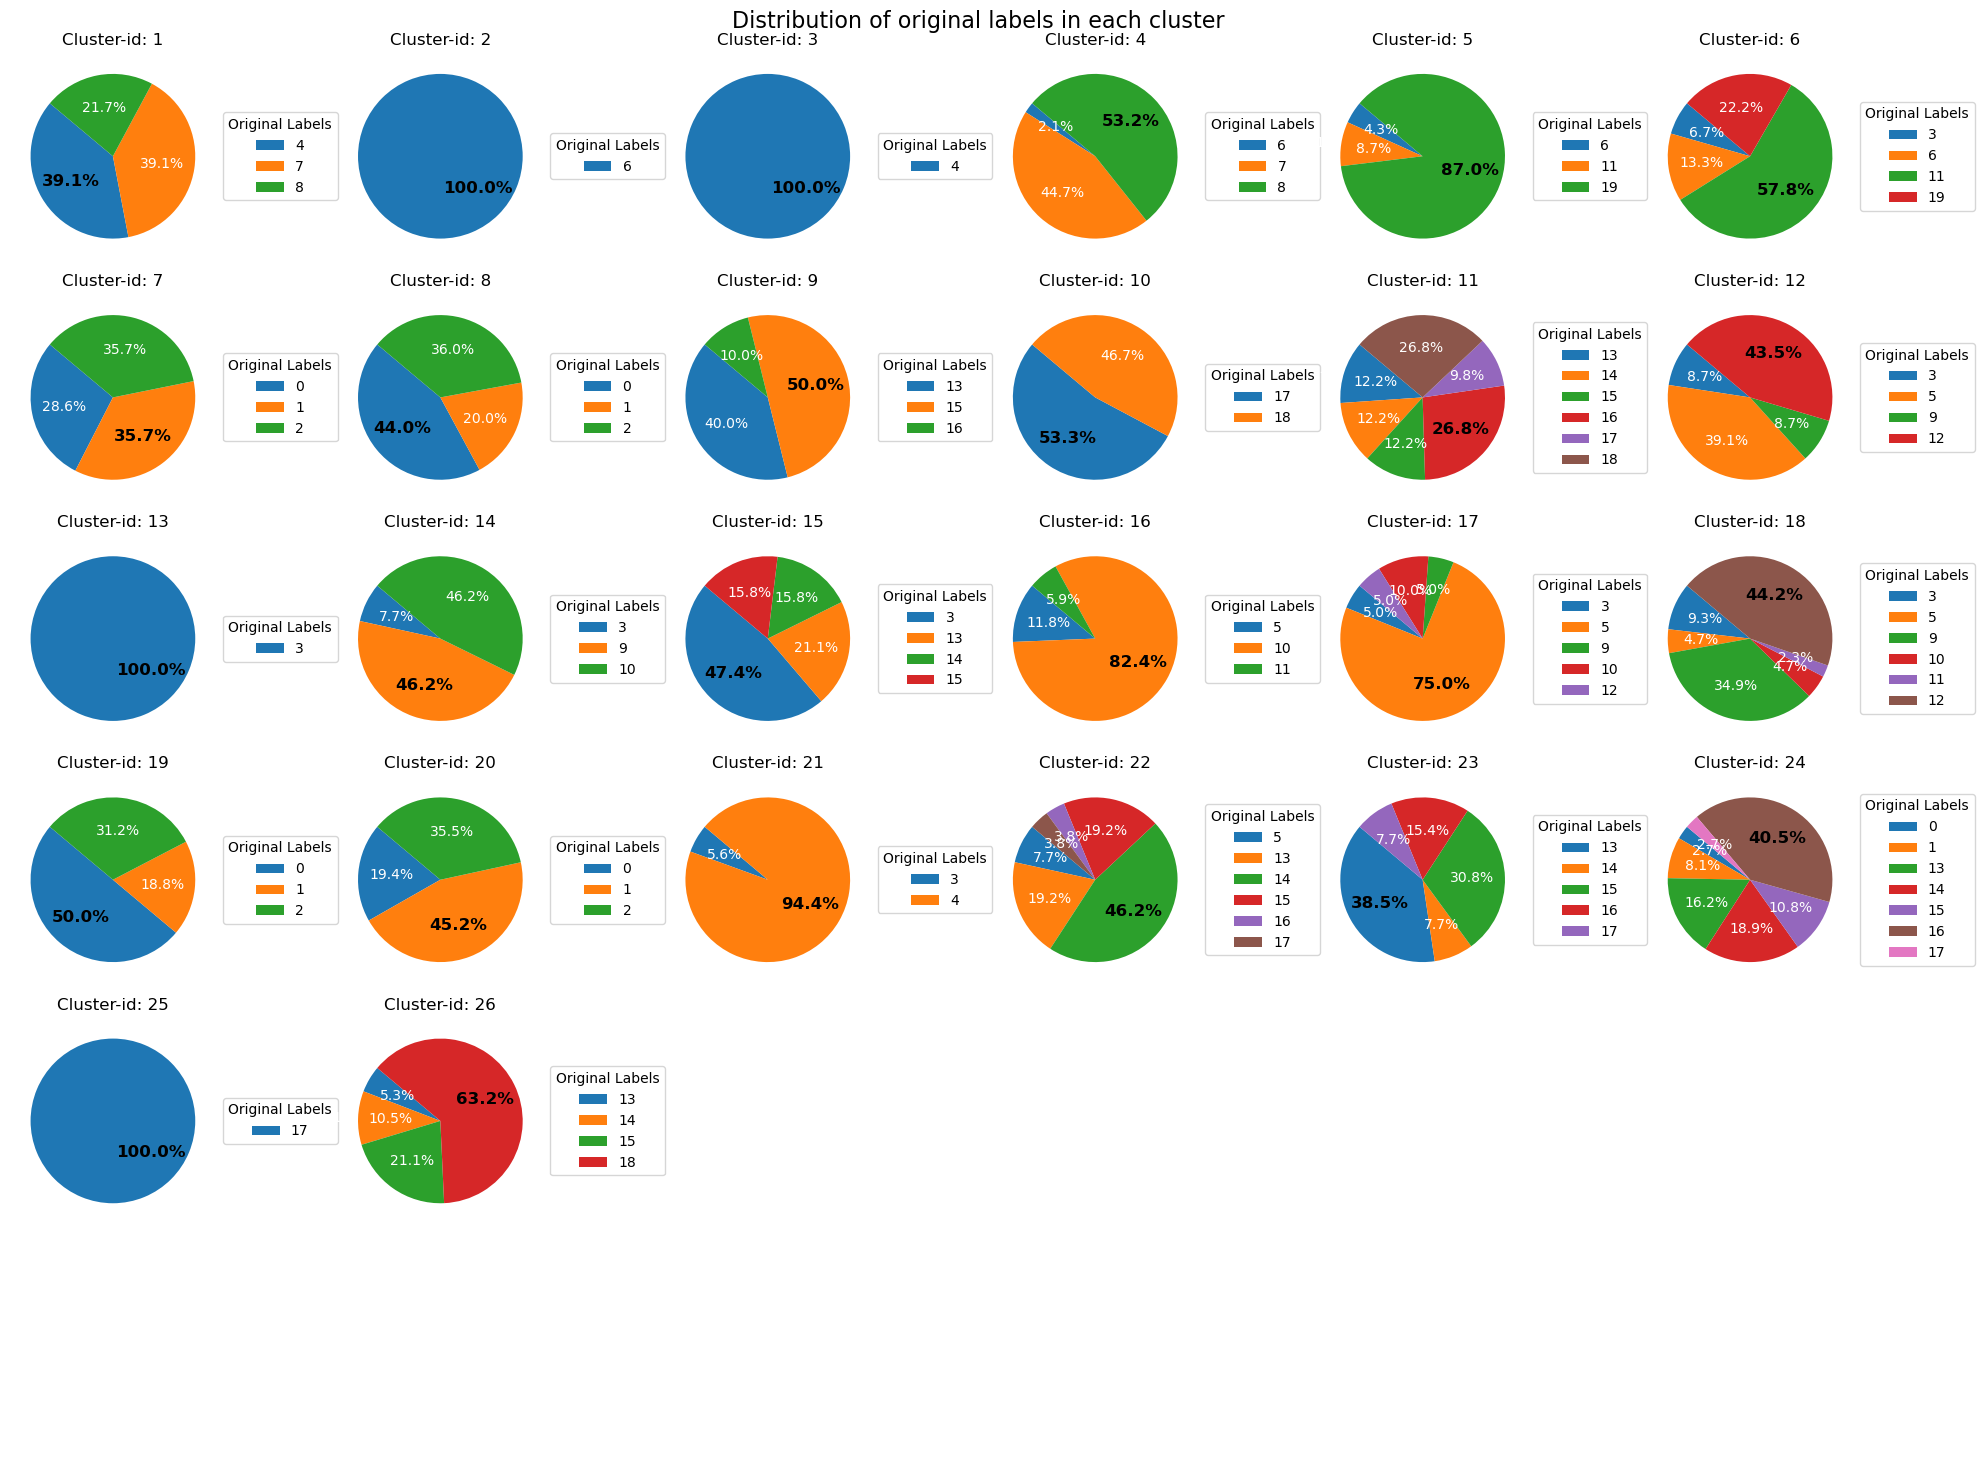

In [26]:
import math
def plot_cluster_distribution_with_majority(original_labels, clustered_labels):
    # Get unique clusters
    unique_clustered_labels = np.unique(clustered_labels)
    
    # Store the results for further sorting
    majority_labels = []
    majority_label_counts = Counter()

    # Calculate grid dimensions
    num_clusters = len(unique_clustered_labels)
    grid_size = math.ceil(math.sqrt(num_clusters))  # Determine size of the grid (square root for square layout)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 15), subplot_kw=dict(aspect="equal"))
    axes = axes.flatten()

    for i, cluster in enumerate(unique_clustered_labels):
        # Filter data for the current cluster
        cluster_data_indices = np.where(clustered_labels == cluster)[0]
        cluster_original_labels = [original_labels[idx] for idx in cluster_data_indices]

        # Count occurrences of original labels in the current cluster
        cluster_original_labels_count = Counter(cluster_original_labels)
        labels = list(cluster_original_labels_count.keys())
        counts = list(cluster_original_labels_count.values())

        # Plot pie chart
        wedges, texts, autotexts = axes[i].pie(
            counts,
            labels=labels,
            autopct=lambda pct: f"{pct:.1f}%" if pct > 0 else '',
            textprops=dict(color="w"),
            startangle=140
        )

        axes[i].legend(wedges, labels, title='Original Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

        # Highlight the largest percentage
        largest_pct_idx = np.argmax(counts)
        autotexts[largest_pct_idx].set_color('black')
        autotexts[largest_pct_idx].set_fontsize(12)
        autotexts[largest_pct_idx].set_fontweight('bold')

        axes[i].set_title(f'Cluster-id: {cluster}')

        # Find majority label for the cluster
        majority_label, count = cluster_original_labels_count.most_common(1)[0]
        total = sum(cluster_original_labels_count.values())
        percentage = (count / total) * 100

        # Append the cluster, majority label, count, and percentage to the list
        majority_labels.append((cluster, majority_label, count, percentage))
        
        majority_label_counts[majority_label] += 1

    # Turn off unused subplots
    for j in range(num_clusters, len(axes)):
        axes[j].axis('off')

    # Separate clusters based on the percentage
    high_majority = [x for x in majority_labels if x[3] > 50]
    low_majority = [x for x in majority_labels if x[3] <= 50]

    # Sort high_majority by cluster ID
    high_majority.sort(key=lambda x: x[0])

    # Sort low_majority by majority label (true label)
    low_majority.sort(key=lambda x: x[1])

    # Print sorted results
    print("\nClusters with majority percentage > 50% (sorted by cluster ID):")
    for cluster, majority_label, count, percentage in high_majority:
        print(f"Cluster {cluster}: Majority label {majority_label} with {count} images ({percentage:.1f}%)")

    print("\nClusters with majority percentage <= 50% (sorted by true label):")
    for cluster, majority_label, count, percentage in low_majority:
        print(f"Cluster {cluster}: Majority label {majority_label} with {count} images ({percentage:.1f}%)")
        
    print("\nFrequency of each original label being the majority across clusters:")
    for label, count in majority_label_counts.items():
        if count > 1:
            print(f"Original label {label}: {count} time(s)")

    plt.suptitle('Distribution of original labels in each cluster', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_cluster_distribution_with_majority(original_labels, cosine_cluster_labels)

Result for metric = Euclidean and linkage = Ward

Cluster labels for each image: Counter({7: 46, 16: 41, 9: 34, 11: 31, 13: 30, 20: 29, 2: 28, 21: 27, 24: 26, 26: 26, 15: 25, 4: 25, 6: 24, 5: 22, 3: 22, 19: 18, 10: 17, 8: 17, 23: 17, 12: 16, 18: 16, 1: 15, 14: 14, 22: 14, 25: 10, 17: 10})


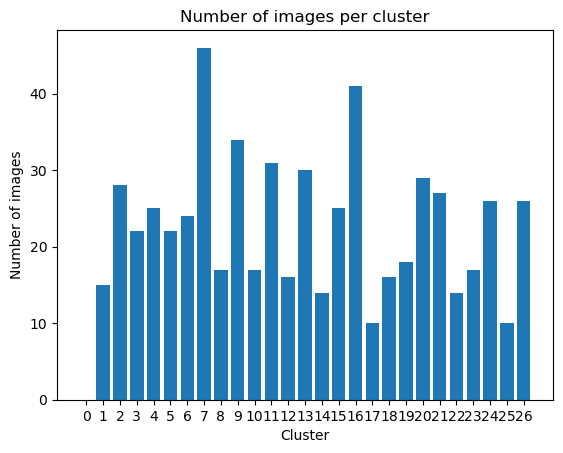


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 1: Majority label 11 with 15 images (100.0%)
Cluster 3: Majority label 6 with 22 images (100.0%)
Cluster 4: Majority label 19 with 21 images (84.0%)
Cluster 5: Majority label 4 with 21 images (95.5%)
Cluster 7: Majority label 8 with 25 images (54.3%)
Cluster 8: Majority label 5 with 9 images (52.9%)
Cluster 12: Majority label 10 with 14 images (87.5%)
Cluster 23: Majority label 16 with 15 images (88.2%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 15: Majority label 0 with 11 images (44.0%)
Cluster 19: Majority label 0 with 8 images (44.4%)
Cluster 14: Majority label 1 with 5 images (35.7%)
Cluster 20: Majority label 1 with 13 images (44.8%)
Cluster 13: Majority label 5 with 15 images (50.0%)
Cluster 6: Majority label 7 with 10 images (41.7%)
Cluster 9: Majority label 9 with 12 images (35.3%)
Cluster 2: Majority label 11 with 10 images (35.7%)
Cluster 10: Majority label 12 with 6 image

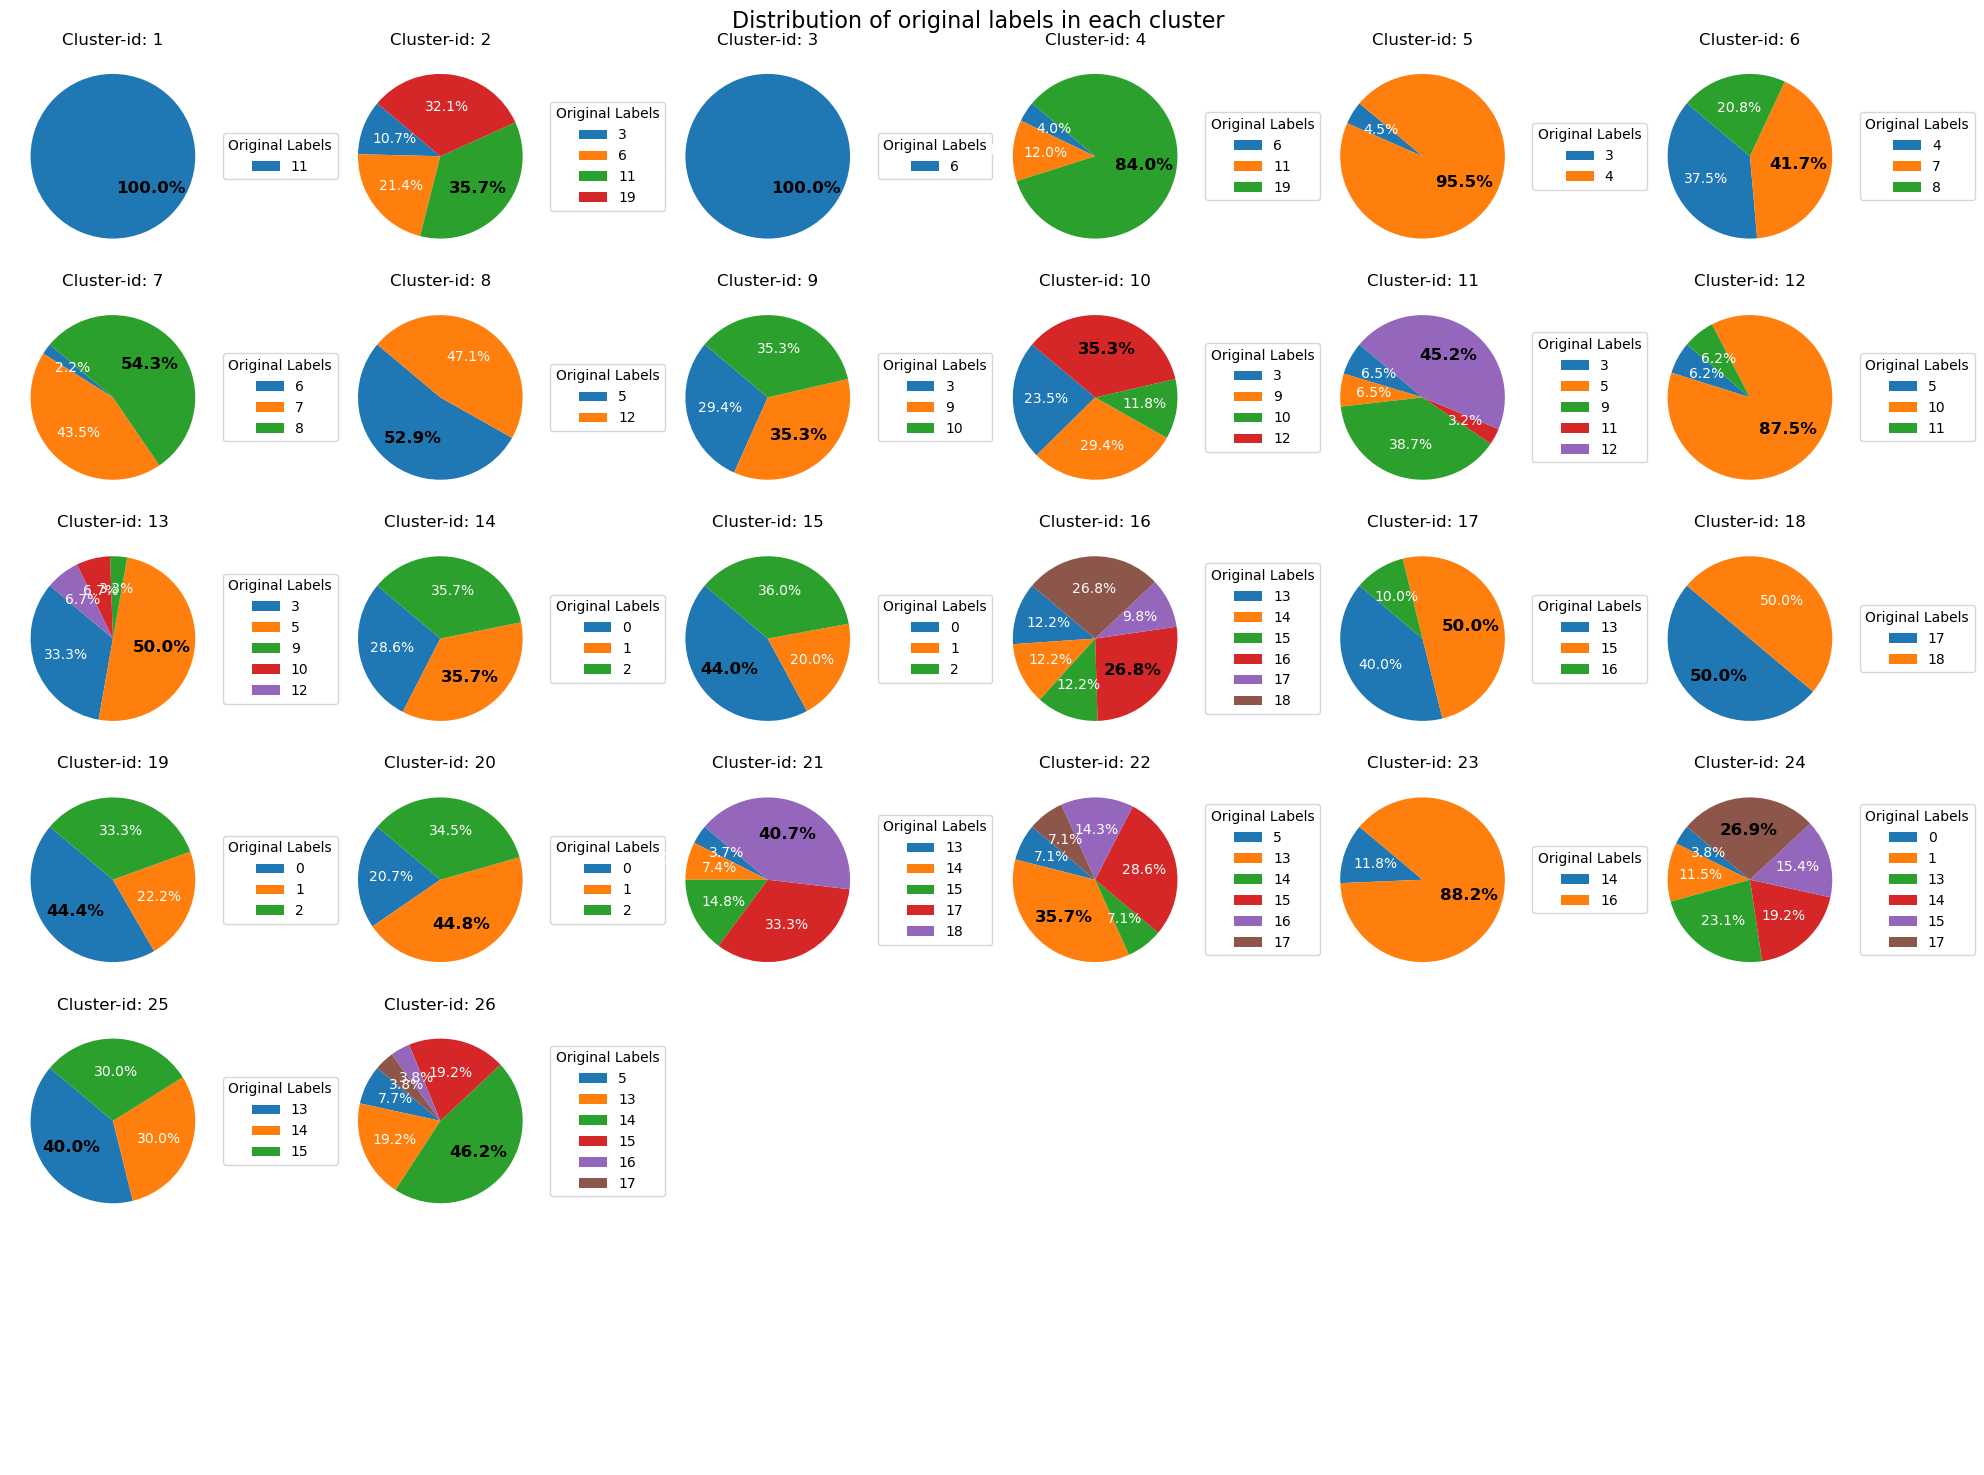

In [27]:
model = HierarchicalModel(best_cluster_num, 'ward', 'euclidean')
euclidean_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(euclidean_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(euclidean_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

plot_cluster_distribution_with_majority(original_labels, euclidean_cluster_labels)

Result for metric = Cityblock and linkage = Average

Cluster labels for each image: Counter({1: 46, 12: 41, 26: 40, 19: 36, 16: 34, 15: 32, 21: 31, 5: 28, 24: 27, 14: 26, 25: 26, 9: 25, 7: 25, 3: 24, 6: 22, 22: 18, 23: 17, 20: 16, 11: 16, 4: 15, 8: 14, 17: 10, 10: 10, 18: 9, 13: 8, 2: 4})


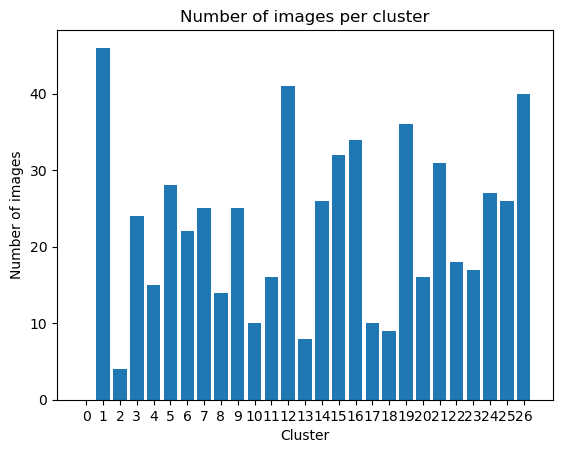


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 1: Majority label 8 with 25 images (54.3%)
Cluster 2: Majority label 4 with 4 images (100.0%)
Cluster 4: Majority label 11 with 15 images (100.0%)
Cluster 6: Majority label 6 with 22 images (100.0%)
Cluster 7: Majority label 19 with 21 images (84.0%)
Cluster 13: Majority label 3 with 8 images (100.0%)
Cluster 18: Majority label 3 with 9 images (100.0%)
Cluster 22: Majority label 4 with 17 images (94.4%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 9: Majority label 0 with 11 images (44.0%)
Cluster 20: Majority label 0 with 8 images (50.0%)
Cluster 8: Majority label 1 with 5 images (35.7%)
Cluster 21: Majority label 1 with 14 images (45.2%)
Cluster 19: Majority label 5 with 16 images (44.4%)
Cluster 3: Majority label 7 with 10 images (41.7%)
Cluster 14: Majority label 9 with 12 images (46.2%)
Cluster 5: Majority label 11 with 10 images (35.7%)
Cluster 15: Majority label 12 with 13 image

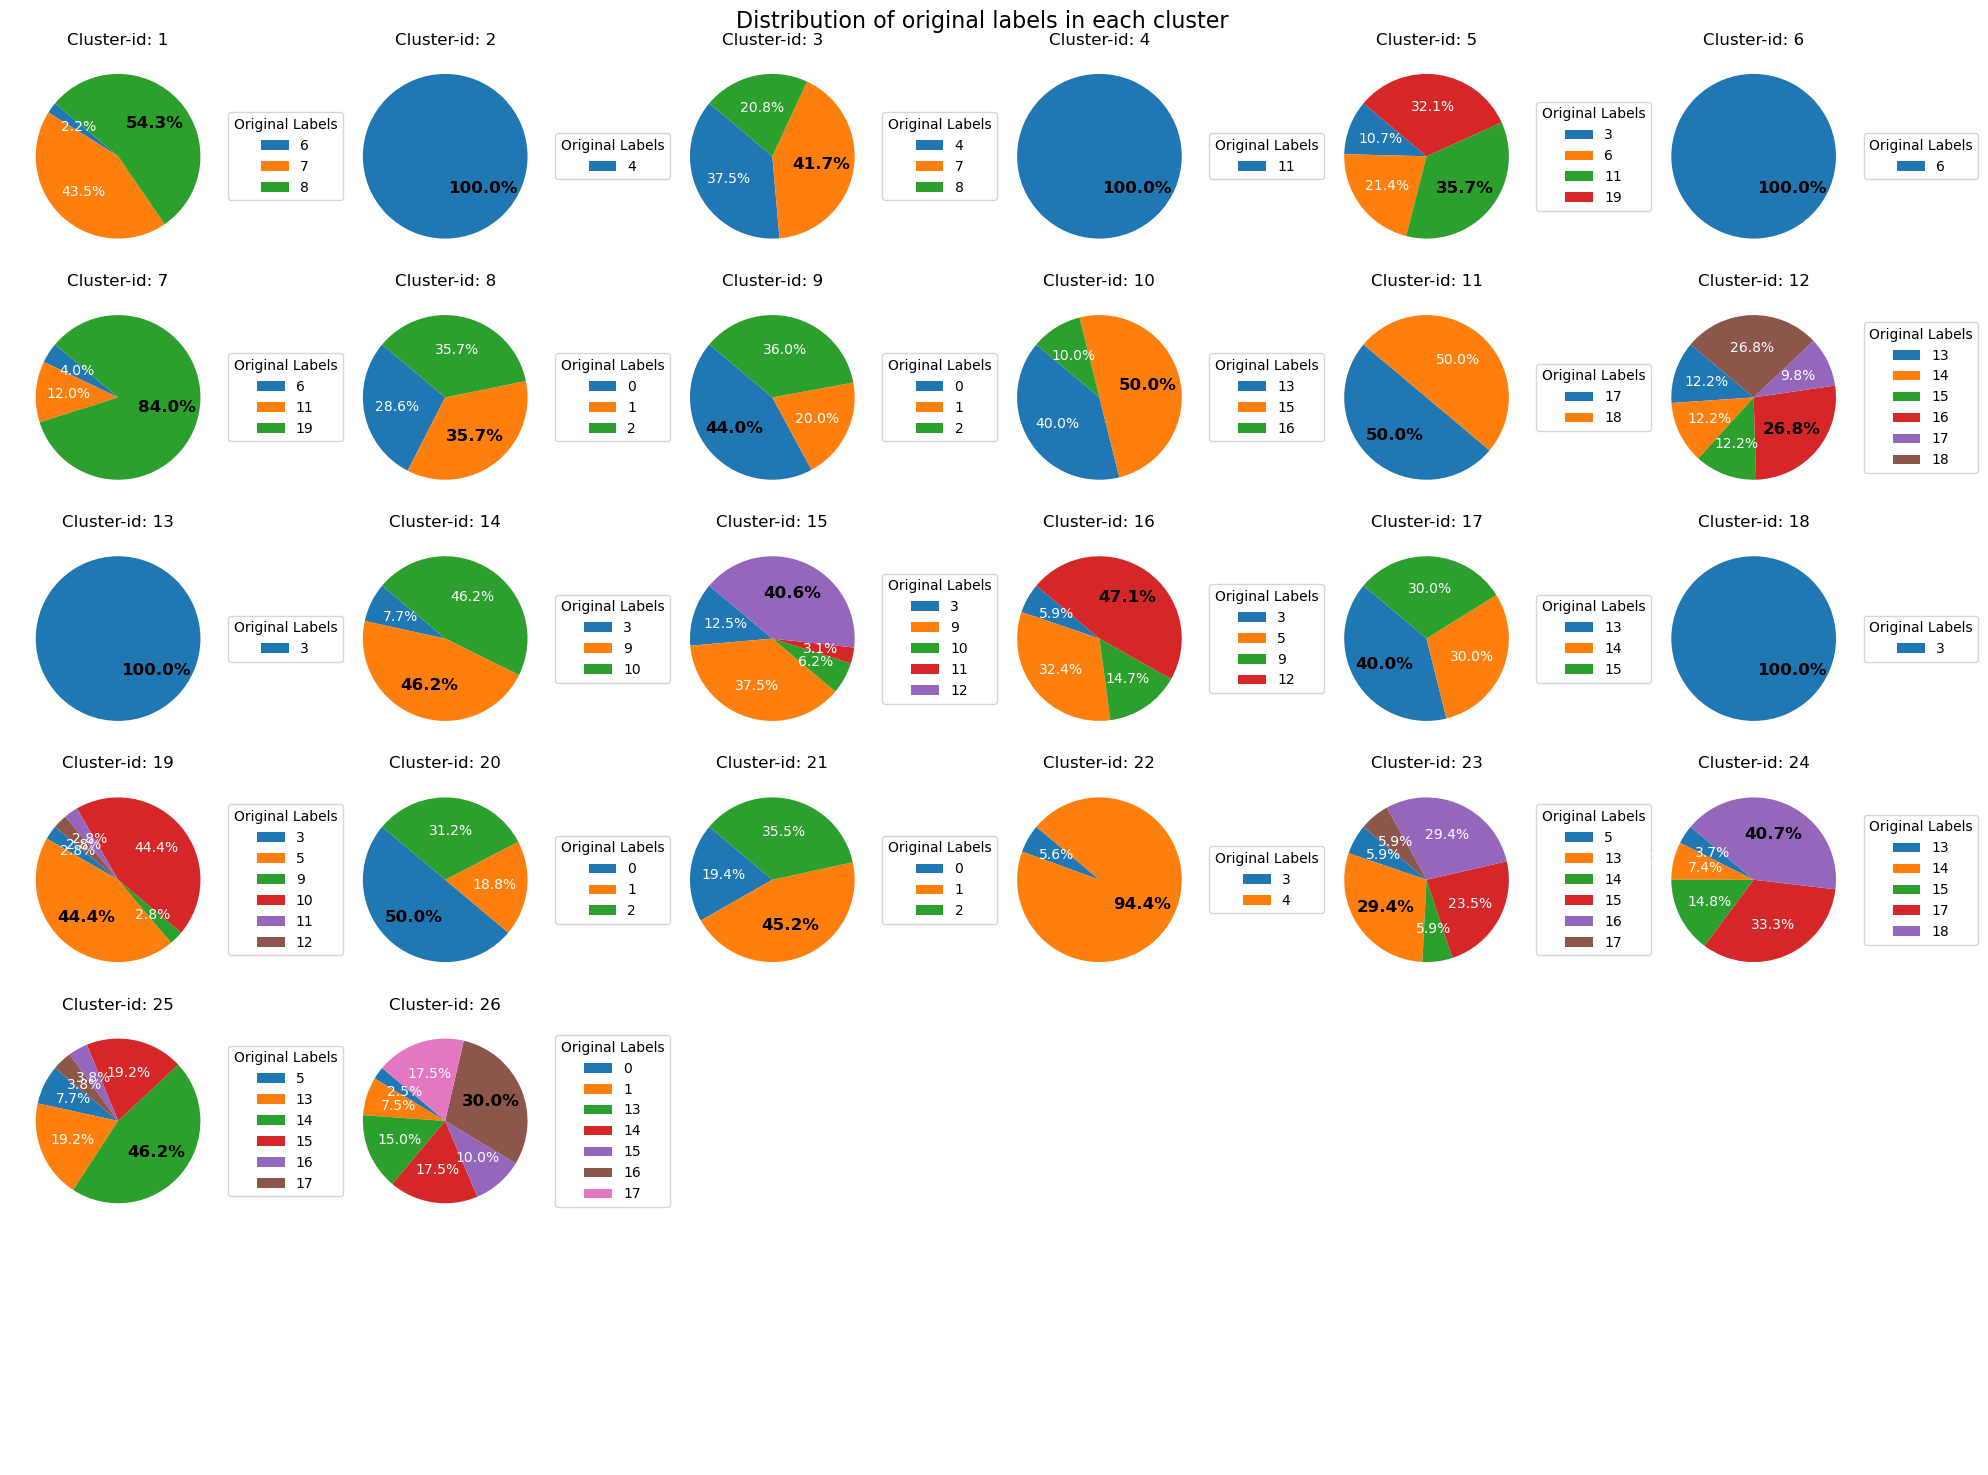

In [28]:
model = HierarchicalModel(best_cluster_num, 'average', 'cityblock')
cityblock_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(cityblock_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(cityblock_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

plot_cluster_distribution_with_majority(original_labels, cityblock_cluster_labels)

Result for metric = Minkowski and linkage = Centroid

Cluster labels for each image: Counter({8: 46, 26: 43, 9: 34, 14: 32, 22: 31, 19: 30, 2: 28, 23: 28, 25: 26, 20: 26, 17: 25, 4: 25, 7: 24, 3: 22, 11: 21, 15: 21, 13: 19, 6: 18, 24: 17, 21: 16, 12: 15, 1: 15, 16: 14, 10: 10, 18: 10, 5: 4})


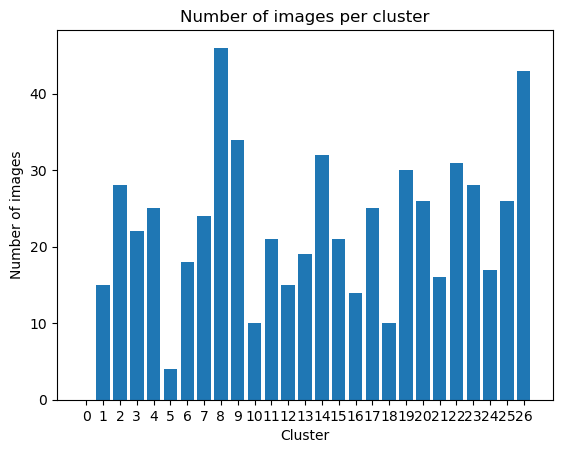


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 1: Majority label 11 with 15 images (100.0%)
Cluster 3: Majority label 6 with 22 images (100.0%)
Cluster 4: Majority label 19 with 21 images (84.0%)
Cluster 5: Majority label 4 with 4 images (100.0%)
Cluster 6: Majority label 4 with 17 images (94.4%)
Cluster 8: Majority label 8 with 25 images (54.3%)
Cluster 12: Majority label 5 with 9 images (60.0%)
Cluster 13: Majority label 12 with 10 images (52.6%)
Cluster 15: Majority label 10 with 13 images (61.9%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 17: Majority label 0 with 11 images (44.0%)
Cluster 21: Majority label 0 with 8 images (50.0%)
Cluster 16: Majority label 1 with 5 images (35.7%)
Cluster 22: Majority label 1 with 14 images (45.2%)
Cluster 11: Majority label 3 with 10 images (47.6%)
Cluster 7: Majority label 7 with 10 images (41.7%)
Cluster 9: Majority label 9 with 12 images (35.3%)
Cluster 2: Majority label 11 with 10 image

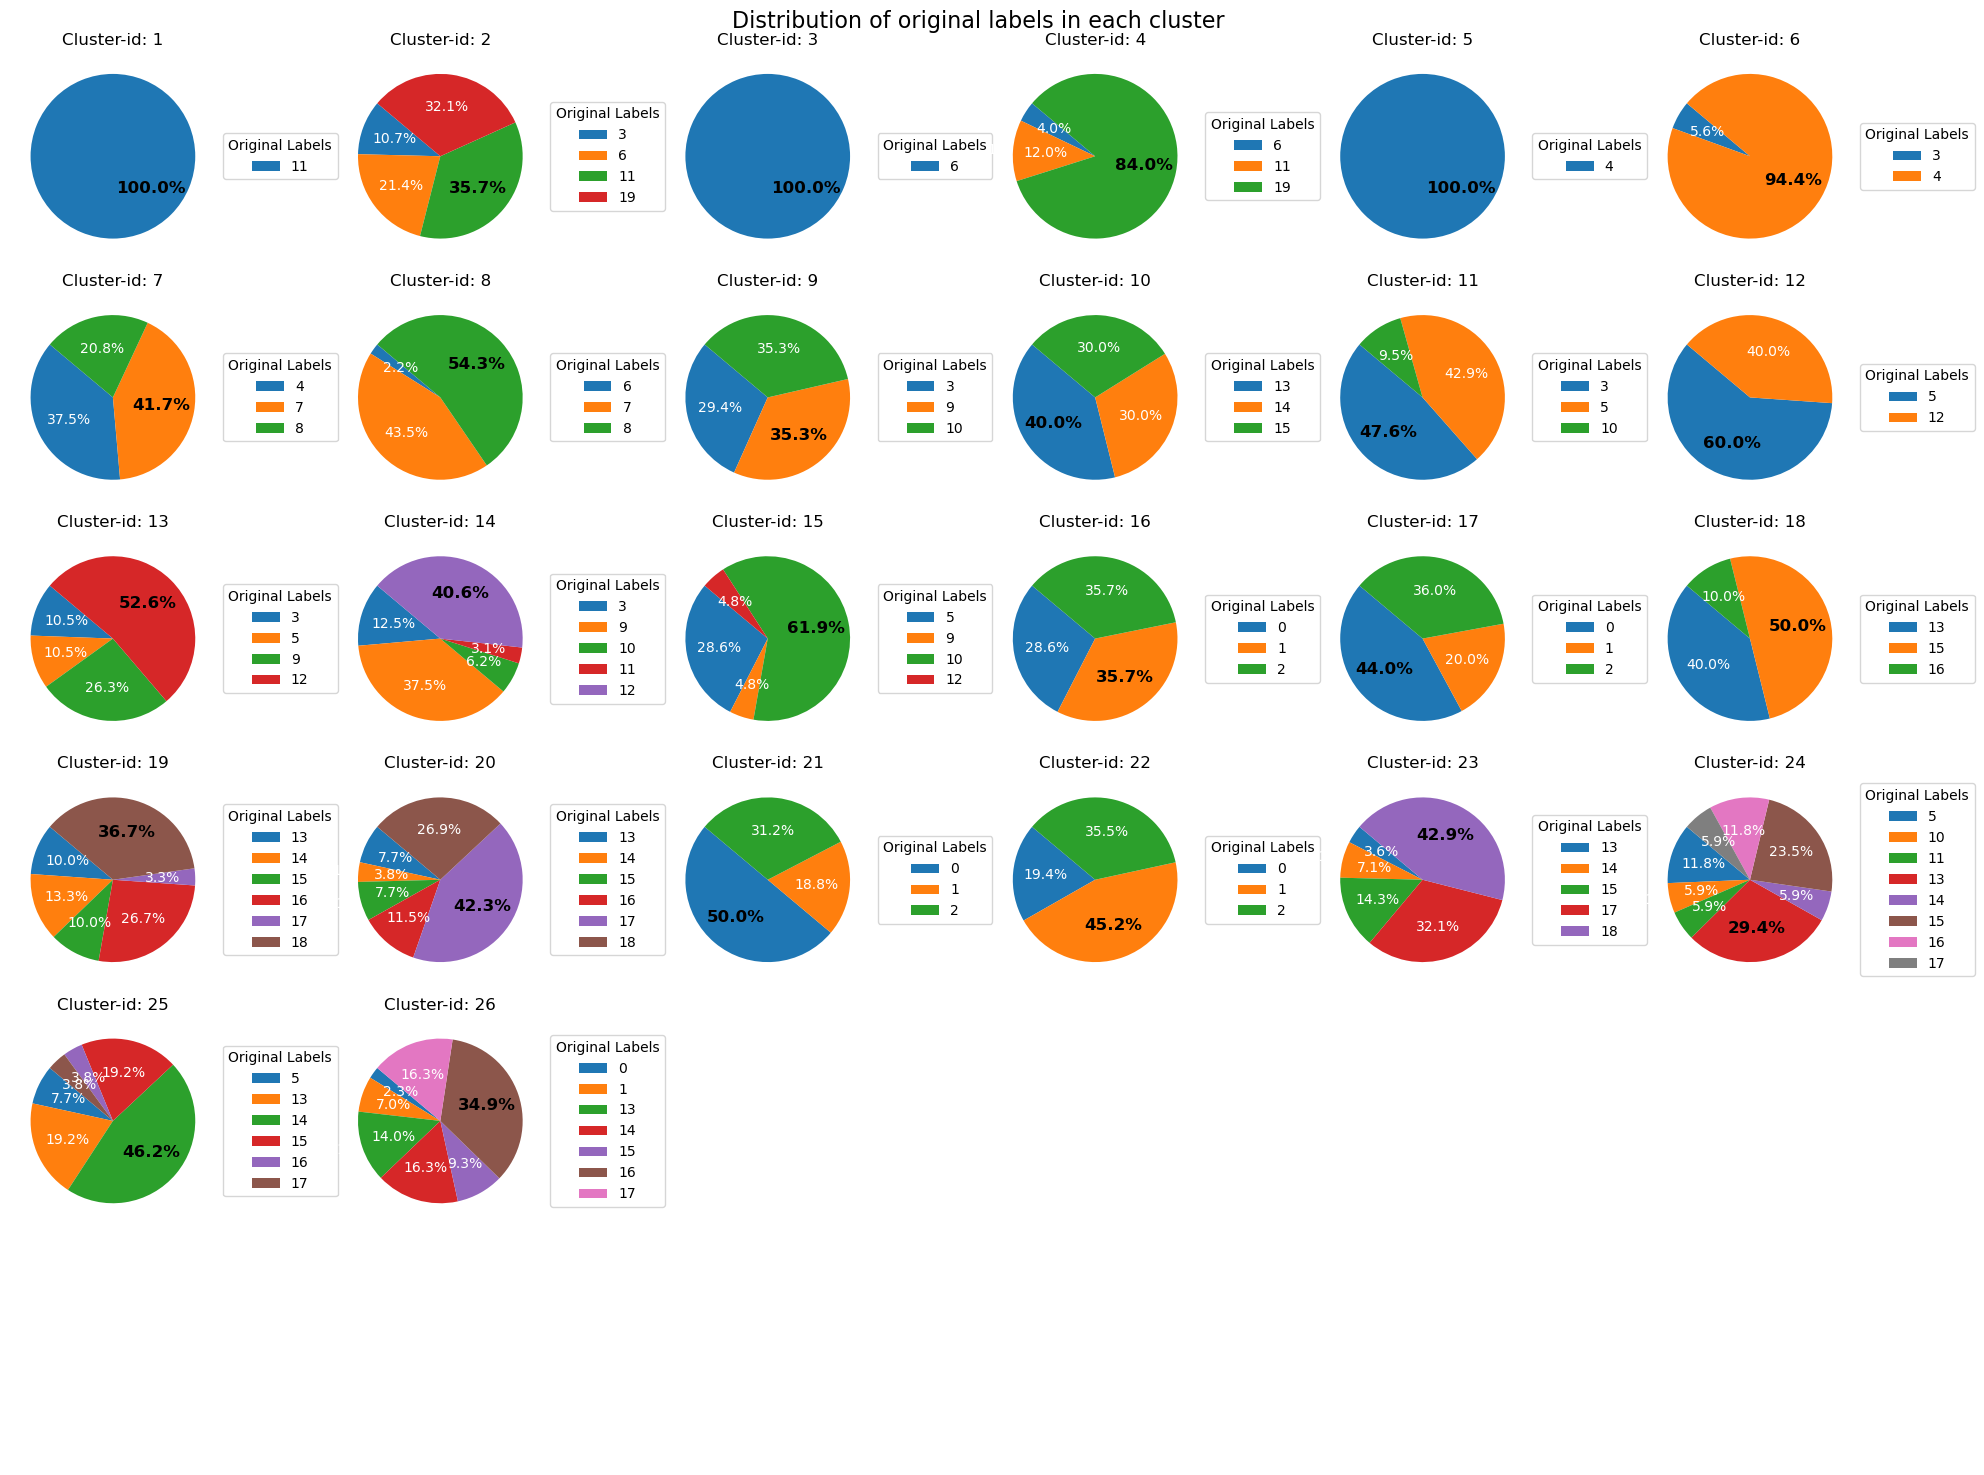

In [29]:
model = HierarchicalModel(best_cluster_num, 'centroid', 'minkowski')
minkowski_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(minkowski_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(minkowski_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

plot_cluster_distribution_with_majority(original_labels, minkowski_cluster_labels)

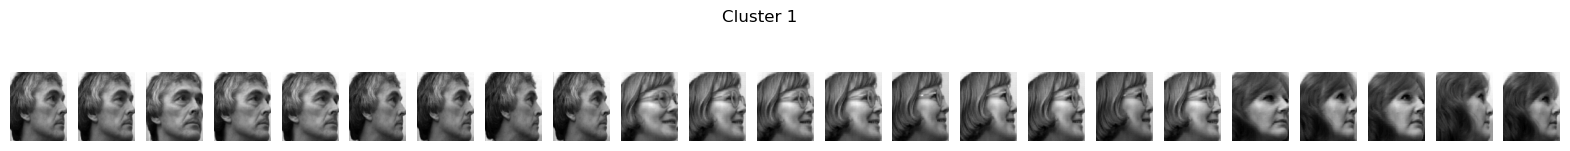

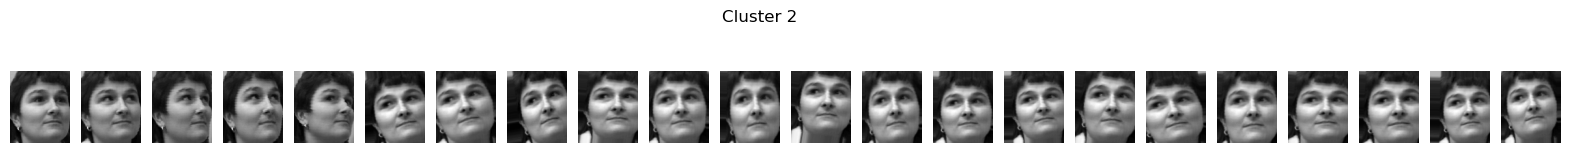

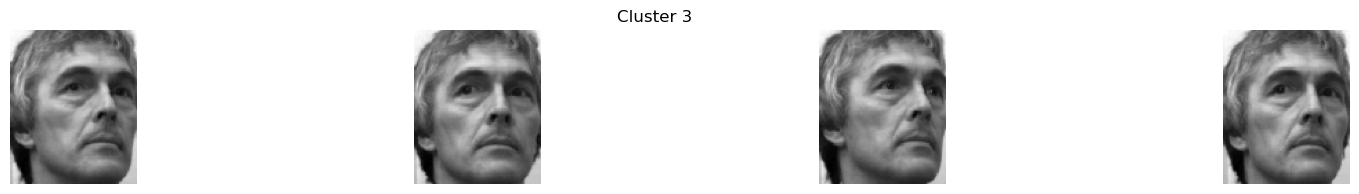

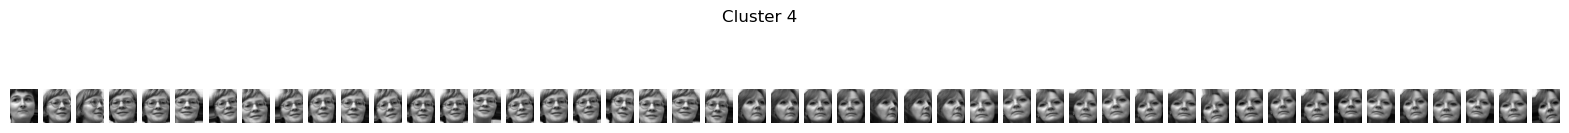

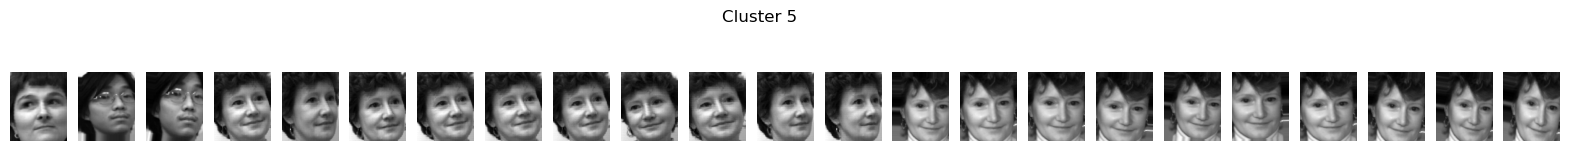

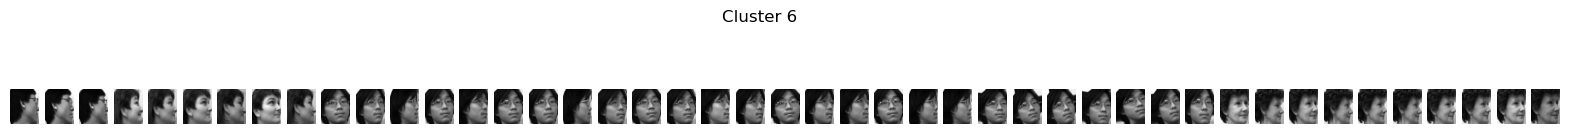

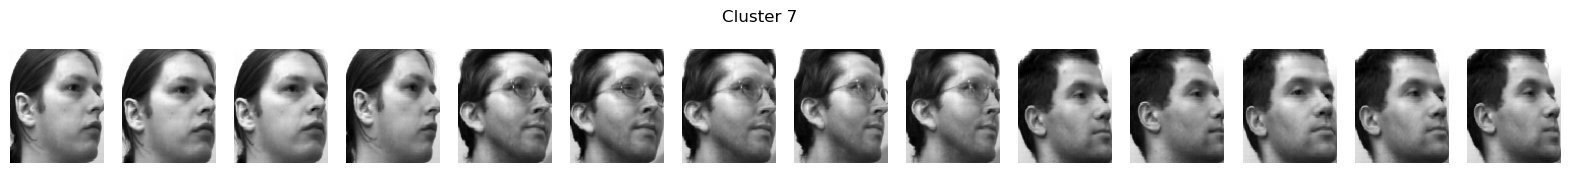

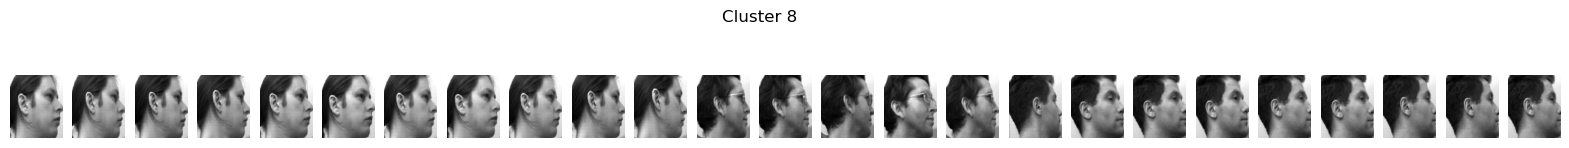

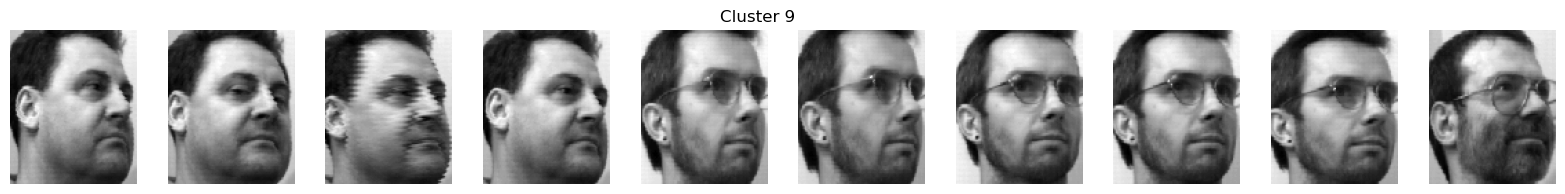

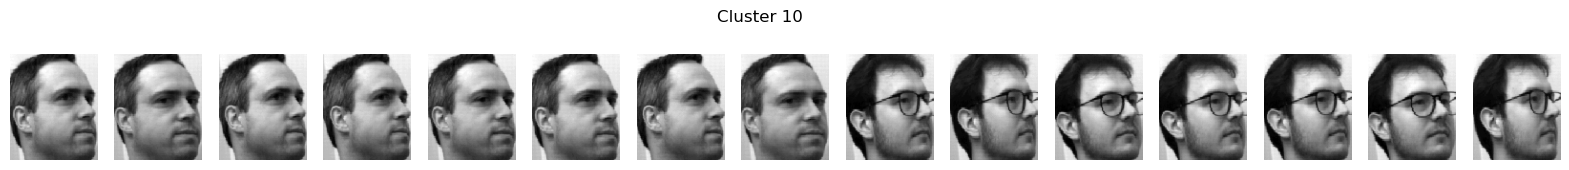

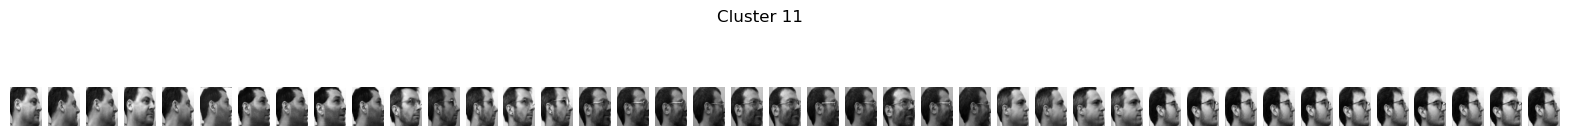

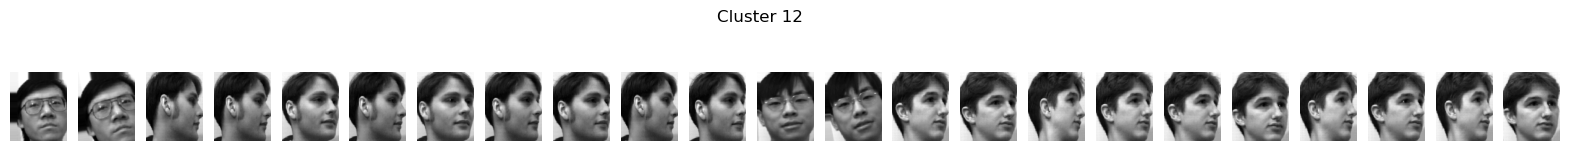

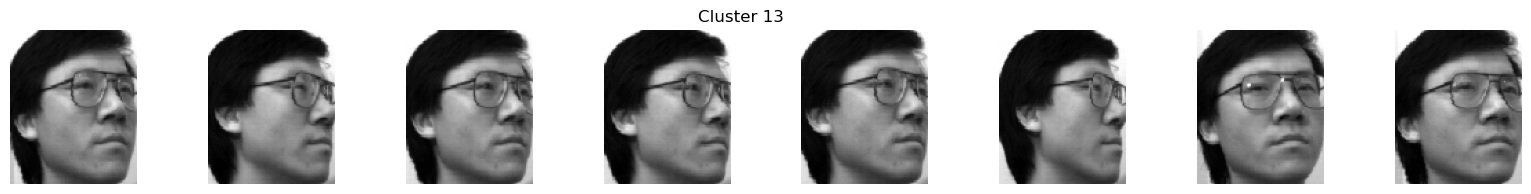

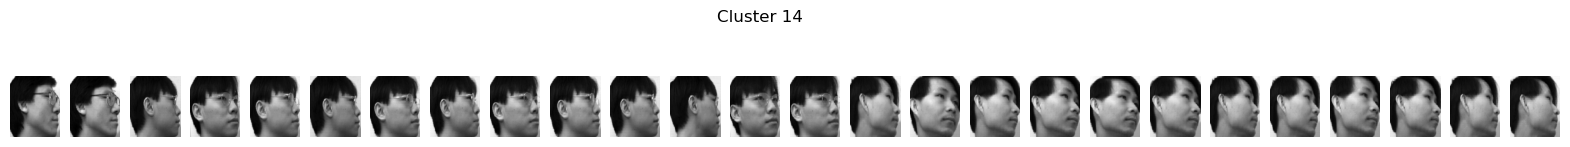

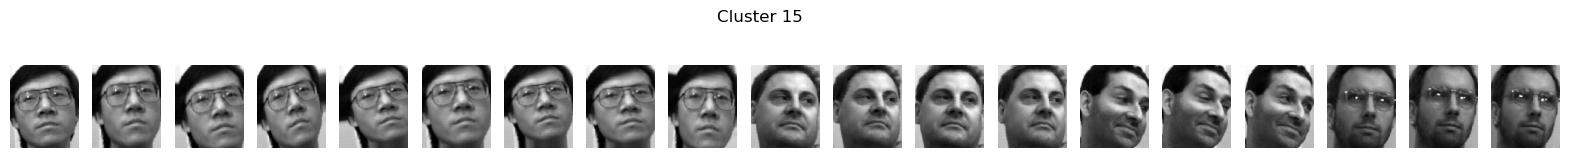

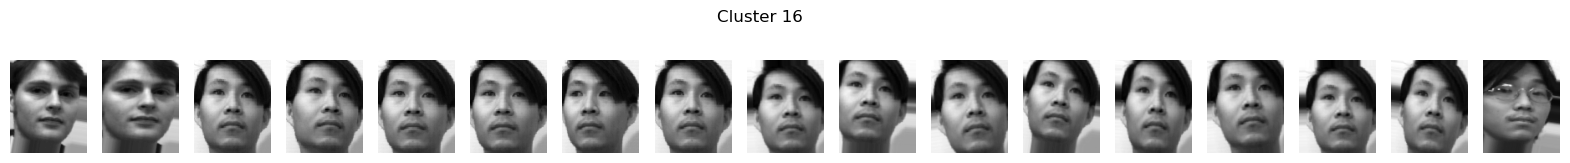

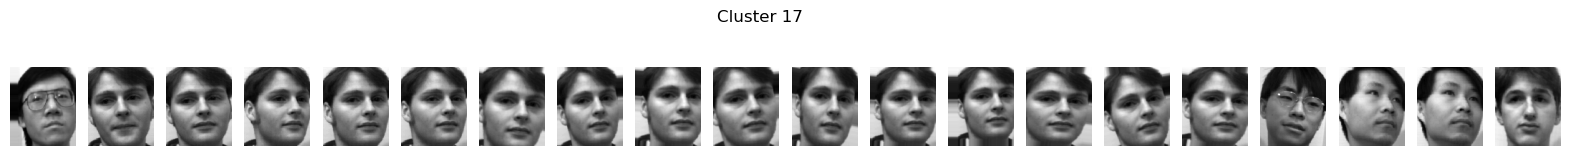

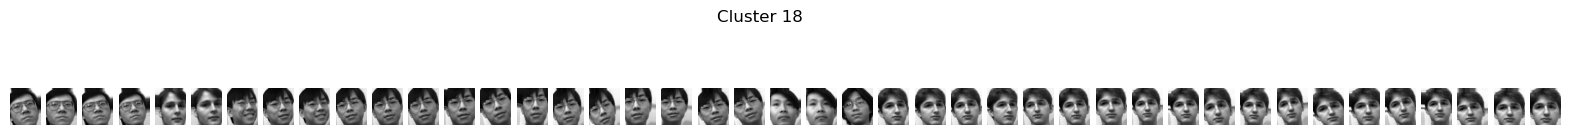

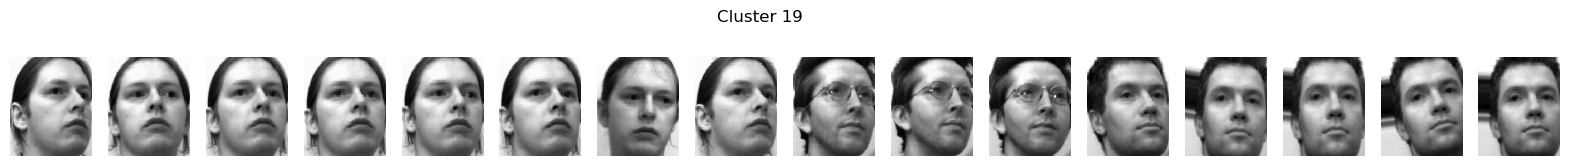

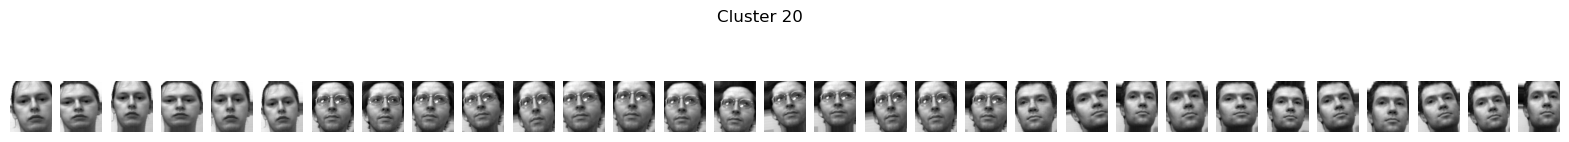

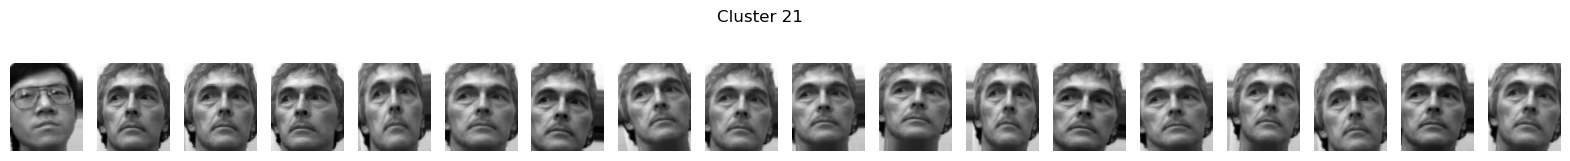

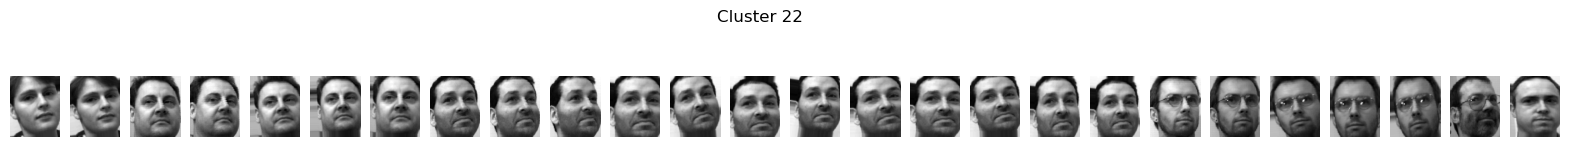

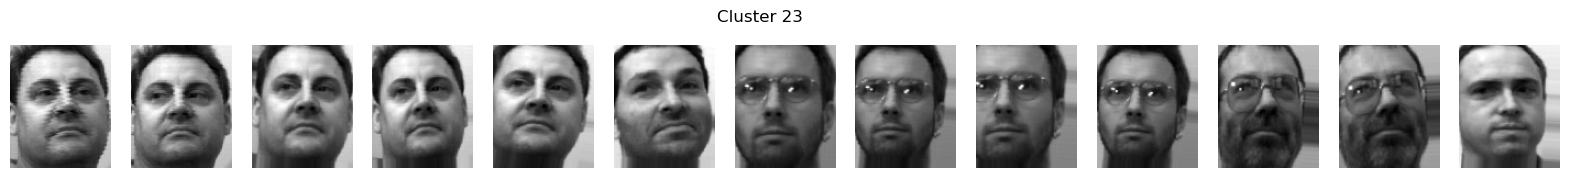

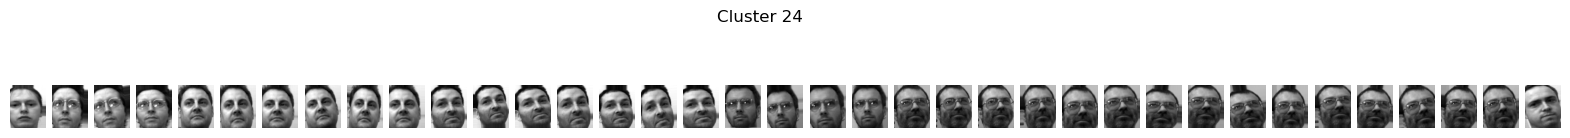

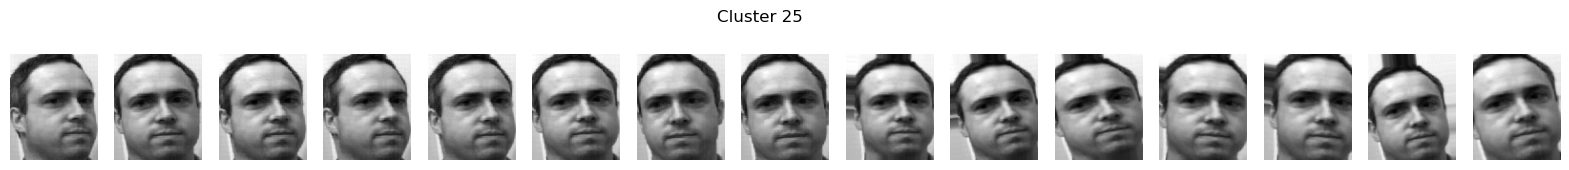

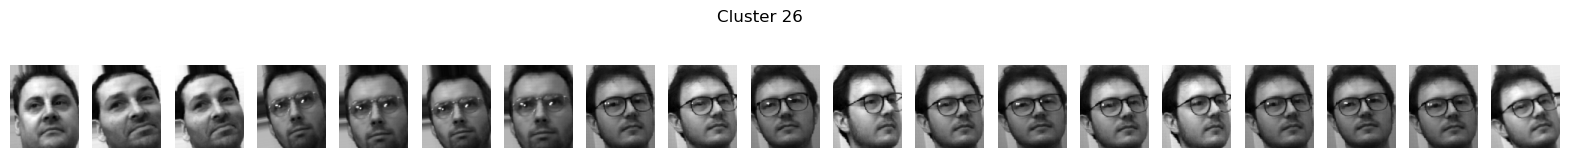

In [30]:
plot_result(cosine_cluster_labels, best_cluster_num)

In [31]:
best_cluster_labels = cosine_cluster_labels

In [32]:
def original_labels_distribution(original_labels, cluster_labels):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    
    label_distribution = {}
    
    for original_label in np.unique(original_labels):
        indices = np.where(original_labels == original_label)[0]
        
        clusters = cluster_labels[indices]
        
        cluster_distribution = Counter(clusters)
        
        most_common_cluster, most_common_count = cluster_distribution.most_common(1)[0]
        
        label_distribution[original_label] = {
            'cluster_distribution': cluster_distribution,
            'most_common_cluster': most_common_cluster,
            'most_common_count': most_common_count
        }
        
        print(f'Original label: {original_label}')
        print(f'Cluster distribution: {cluster_distribution}')
        print(f'Most common cluster: {most_common_cluster} ({most_common_count}/{len(indices)} img)')
        print("*******************************************")

In [33]:
original_labels_distribution(original_labels, best_cluster_labels)

Original label: 0
Cluster distribution: Counter({8: 11, 19: 8, 20: 6, 7: 4, 24: 1})
Most common cluster: 8 (11/30 img)
*******************************************
Original label: 1
Cluster distribution: Counter({20: 14, 8: 5, 7: 5, 19: 3, 24: 3})
Most common cluster: 20 (14/30 img)
*******************************************
Original label: 2
Cluster distribution: Counter({20: 11, 8: 9, 7: 5, 19: 5})
Most common cluster: 20 (11/30 img)
*******************************************
Original label: 3
Cluster distribution: Counter({15: 9, 13: 8, 18: 4, 6: 3, 14: 2, 12: 2, 17: 1, 21: 1})
Most common cluster: 15 (9/30 img)
*******************************************
Original label: 4
Cluster distribution: Counter({21: 17, 1: 9, 3: 4})
Most common cluster: 21 (17/30 img)
*******************************************
Original label: 5
Cluster distribution: Counter({17: 15, 12: 9, 16: 2, 22: 2, 18: 2})
Most common cluster: 17 (15/30 img)
*******************************************
Original label: 